In [1]:
# ================================================================
# 0. FIX IMPORT ERRORS FIRST
# ================================================================
!pip install --quiet protobuf==3.20.3

# ================================================================
# 1. IMPORTS
# ================================================================
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

from tensorflow.keras.layers import (
    Dense, Input, Layer, GlobalAveragePooling1D, LayerNormalization, 
    Lambda, Dropout, Reshape, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print("Imports loaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

2025-12-07 15:30:24.585450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765121424.887683      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765121424.972694      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Imports loaded.


In [2]:
# ============================================================
# 2. CUSTOM LAYERS (UNCHANGED)
# ============================================================

class MultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.d_model = num_heads * key_dim
        
        self.query_dense = Dense(self.d_model)
        self.key_dense = Dense(self.d_model)
        self.value_dense = Dense(self.d_model)
        self.combine_heads = Dense(self.d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.key_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, value, key):
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        
        return self.combine_heads(output)


class VisionTemporalTransformer(Layer):
    def __init__(self, patch_size=8, d_model=128, num_heads=4, spatial_layers=1, temporal_layers=1, **kwargs):
        super(VisionTemporalTransformer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.spatial_layers = spatial_layers
        self.temporal_layers = temporal_layers

        self.dense_projection = Dense(d_model)
        self.pos_emb = None

        self.spatial_mhas = [MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) for _ in range(spatial_layers)]
        self.spatial_norm1 = [LayerNormalization() for _ in range(spatial_layers)]
        self.spatial_ffn = [tf.keras.Sequential([Dense(d_model*4, activation='relu'), Dense(d_model)]) for _ in range(spatial_layers)]
        self.spatial_norm2 = [LayerNormalization() for _ in range(spatial_layers)]

        self.temporal_mhas = [MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) for _ in range(temporal_layers)]
        self.temporal_norm1 = [LayerNormalization() for _ in range(temporal_layers)]
        self.temporal_ffn = [tf.keras.Sequential([Dense(d_model*4, activation='relu'), Dense(d_model)]) for _ in range(temporal_layers)]
        self.temporal_norm2 = [LayerNormalization() for _ in range(temporal_layers)]

    def build(self, input_shape):
        H = input_shape[2]
        W = input_shape[3]
        ph = H // self.patch_size
        pw = W // self.patch_size
        num_patches = ph * pw
        self.pos_emb = self.add_weight(shape=(1, num_patches, self.d_model), initializer='random_normal', trainable=True, name='pos_emb')
        super(VisionTemporalTransformer, self).build(input_shape)

    def call(self, inputs):
        shape = tf.shape(inputs)
        batch = shape[0]
        frames = shape[1]
        H = shape[2]
        W = shape[3]
        C = inputs.shape[-1]

        reshaped = tf.reshape(inputs, (-1, H, W, C))

        patches = tf.image.extract_patches(
            images=reshaped,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding='VALID'
        )

        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, (-1, tf.shape(patches)[1] * tf.shape(patches)[2], patch_dim))

        x = self.dense_projection(patches) + self.pos_emb

        for i in range(self.spatial_layers):
            attn = self.spatial_mhas[i](x, value=x, key=x)
            x = self.spatial_norm1[i](x + attn)
            ff = self.spatial_ffn[i](x)
            x = self.spatial_norm2[i](x + ff)

        x = tf.reshape(x, (batch, frames, -1, self.d_model))
        x = tf.reduce_mean(x, axis=2)
        x.set_shape([None, None, self.d_model])

        for i in range(self.temporal_layers):
            attn = self.temporal_mhas[i](x, value=x, key=x)
            x = self.temporal_norm1[i](x + attn)
            ff = self.temporal_ffn[i](x)
            x = self.temporal_norm2[i](x + ff)

        pooled = GlobalAveragePooling1D()(x)
        return pooled


In [3]:
# ============================================================
# 3. MODEL DEFINITION (UNCHANGED)
# ============================================================

def batch_consistency_loss(y_true, features):
    f = tf.reshape(features, (tf.shape(features)[0], -1))
    f_norm = tf.math.l2_normalize(f, axis=1)
    sim_matrix = tf.matmul(f_norm, f_norm, transpose_b=True)
    avg_sim = tf.reduce_mean(sim_matrix, axis=1)
    return 1.0 - avg_sim

def consistency_loss_wrapper(y_true, y_pred):
    return batch_consistency_loss(y_true, y_pred)


def build_lipinc_model(frame_shape=(8,64,144,3), residue_shape=(7,64,144,3), d_model=128):
    frame_input = Input(shape=frame_shape, name='FrameInput')
    residue_input = Input(shape=residue_shape, name='ResidueInput')

    vt = VisionTemporalTransformer(
        patch_size=8, d_model=d_model, num_heads=4, spatial_layers=1, temporal_layers=1
    )

    frame_feat = vt(frame_input)
    residue_feat = vt(residue_input)

    expand1 = Lambda(lambda x: tf.expand_dims(x, axis=1))
    q = expand1(frame_feat)
    k = expand1(residue_feat)
    v = k

    mha = MultiHeadAttention(num_heads=4, key_dim=d_model//4)
    attn_out = mha(q, value=v, key=k)
    attn_out = Lambda(lambda x: tf.squeeze(x, axis=1))(attn_out)

    fusion = Lambda(lambda t: tf.concat(t, axis=1))([frame_feat, residue_feat, attn_out])

    x = Dense(512, activation='relu')(fusion)
    x = Dense(256, activation='relu')(x)

    class_output = Dense(2, activation='softmax', name='class_output')(x)
    features_output = Dense(d_model, activation=None, name='features_output')(x)

    model = Model(
        inputs=[frame_input, residue_input],
        outputs=[class_output, features_output],
        name='LIPINC_cleaned'
    )
    return model

print("Model architecture loaded.")


Model architecture loaded.


In [4]:
# ============================================================
# 4. VIDEO DATA GENERATOR (FIXED VERSION)
# ============================================================

class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size=16, frame_count=8, dim=(64, 144), shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.frame_count = frame_count
        self.dim = dim
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.video_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_paths = [self.video_paths[k] for k in indexes]
        list_labels = [self.labels[k] for k in indexes]
        return self.__data_generation(list_paths, list_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        try:
            while len(frames) < self.frame_count:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, (self.dim[1], self.dim[0]))
                frames.append(frame)
        finally:
            cap.release()

        frames = np.array(frames)

        if len(frames) == 0:
            return np.zeros((self.frame_count, self.dim[0], self.dim[1], 3), dtype=np.float32)

        if len(frames) < self.frame_count:
            padding = np.zeros((self.frame_count - len(frames), self.dim[0], self.dim[1], 3))
            frames = np.concatenate([frames, padding], axis=0)

        return frames.astype(np.float32) / 255.0

    def compute_residue(self, frames):
        residues = np.zeros((self.frame_count - 1, self.dim[0], self.dim[1], 3), dtype=np.float32)
        if len(frames) > 1:
            for i in range(1, len(frames)):
                residues[i-1] = frames[i] - frames[i-1]
        return residues

    def __data_generation(self, list_paths, list_labels):
        X_frames = np.empty((self.batch_size, self.frame_count, *self.dim, 3))
        X_residues = np.empty((self.batch_size, self.frame_count - 1, *self.dim, 3))
        y = np.empty((self.batch_size, 2), dtype=int)
        dummy_feats = np.zeros((self.batch_size, 128))

        for i, path in enumerate(list_paths):
            frames = self.load_video(path)
            X_frames[i] = frames
            X_residues[i] = self.compute_residue(frames)
            y[i] = list_labels[i]

        # 🚀 FIXED RETURN → MUST BE TUPLES (NOT LISTS)
        return (X_frames, X_residues), {
            'class_output': y,
            'features_output': dummy_feats
        }


In [5]:
# ============================================================
# 5. LOAD DATASETS (DFD + FF++, NO DFDC)
# ============================================================

print("Scanning Datasets...")

# --- DFD ---
DFD_REAL_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
DFD_FAKE_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences"

dfd_real = glob(os.path.join(DFD_REAL_PATH, '**', '*.mp4'), recursive=True)
dfd_fake = glob(os.path.join(DFD_FAKE_PATH, '**', '*.mp4'), recursive=True)

if not dfd_real:
    dfd_real = glob(os.path.join(DFD_REAL_PATH, '**', '*.avi'), recursive=True)
if not dfd_fake:
    dfd_fake = glob(os.path.join(DFD_FAKE_PATH, '**', '*.avi'), recursive=True)

# --- FF++ REAL ONLY ---
FF_REAL_PATH = "/kaggle/input/ff-c23/FaceForensics++_C23/original"
ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.mp4'), recursive=True)
if not ff_real:
    ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.avi'), recursive=True)

# --- FF++ FAKE NOT USED ---
print(f"Counts -> DFD: {len(dfd_real)}/{len(dfd_fake)} | FF++: {len(ff_real)} real")

# Combine REAL datasets
all_real_paths = np.array(dfd_real + ff_real)
all_fake_paths = np.array(dfd_fake)

n_real = len(all_real_paths)
n_fake = len(all_fake_paths)

print("Using DFD (real+fake) and FF++ real only")
print(f"Total Available -> Real: {n_real}, Fake: {n_fake}")

# Balance dataset
if n_fake > n_real:
    undersampled_fake_paths = np.random.choice(all_fake_paths, n_real, replace=False)
    final_fake_paths = undersampled_fake_paths
else:
    final_fake_paths = all_fake_paths

final_real_paths = all_real_paths

# Labels
final_real_labels = [[1, 0]] * len(final_real_paths)
final_fake_labels = [[0, 1]] * len(final_fake_paths)

# Merge
all_paths = np.concatenate([final_real_paths, final_fake_paths])
all_labels = np.array(final_real_labels + final_fake_labels)

print(f"Final Balanced Dataset: {len(all_paths)} total videos ({len(final_real_paths)} Real, {len(final_fake_paths)} Fake)")

# Split train/val/test
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    all_paths, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training on: {len(X_train_paths)}")
print(f"Validation on: {len(X_val_paths)}")
print(f"Testing on: {len(X_test_paths)}")


Scanning Datasets...
Counts -> DFD: 363/3068 | FF++: 1000 real
Using DFD (real+fake) and FF++ real only
Total Available -> Real: 1363, Fake: 3068
Final Balanced Dataset: 2726 total videos (1363 Real, 1363 Fake)
Training on: 1908
Validation on: 409
Testing on: 409


In [6]:
# ============================================================
# 6. GENERATORS
# ============================================================

BATCH_SIZE = 16

train_gen = VideoDataGenerator(X_train_paths, y_train, batch_size=BATCH_SIZE)
val_gen = VideoDataGenerator(X_val_paths, y_val, batch_size=BATCH_SIZE)
test_gen = VideoDataGenerator(X_test_paths, y_test, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
# ============================================================
# 7. MODEL TRAINING (UNCHANGED)
# ============================================================

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = build_lipinc_model()
model.summary()

opt = Adam(learning_rate=1e-5)
model.compile(
    optimizer=opt,
    loss={
        'class_output': 'categorical_crossentropy',
        'features_output': consistency_loss_wrapper
    },
    loss_weights={
        'class_output': 1.0,
        'features_output': 1.0
    },
    metrics={'class_output': 'accuracy'}
)

checkpoint = ModelCheckpoint(
    'best_lipinc_model.h5',
    monitor='val_class_output_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_class_output_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

model.save('lipinc_full_data_final.h5')
print("Model saved.")


I0000 00:00:1765121457.309559      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "LIPINC_cleaned"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ FrameInput          │ (None, 8, 64,     │          0 │ -                 │
│ (InputLayer)        │ 144, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidueInput        │ (None, 7, 64,     │          0 │ -                 │
│ (InputLayer)        │ 144, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_temporal_tr… │ (None, 128)       │    439,680 │ FrameInput[0][0], │
│ (VisionTemporalTra… │                   │            │ ResidueInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 128)    │          0 │ vision_temporal_… │
│                     │                   │            │ vision_temporal_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 128) │     66,048 │ lambda[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lambda[1][0],     │
│                     │                   │            │ lambda[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 384)       │          0 │ vision_temporal_… │
│                     │                   │            │ vision_temporal_… │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │    197,120 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    131,328 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 2)         │        514 │ dense_18[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_output     │ (None, 128)       │     32,896 │ dense_18[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 867,586 (3.31 MB)

 Trainable params: 867,586 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1765121477.840105      67 service.cc:148] XLA service 0x7f8b6000aa10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765121477.841557      67 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765121479.665295      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/119 ━━━━━━━━━━━━━━━━━━━━ 46:48 24s/step - class_output_accuracy: 0.4375 - class_output_loss: 1.1047 - features_output_loss: 0.0129 - loss: 1.1176

I0000 00:00:1765121486.846291      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - class_output_accuracy: 0.5423 - class_output_loss: 0.7278 - features_output_loss: 0.0085 - loss: 0.7363
Epoch 1: val_class_output_accuracy improved from -inf to 0.55750, saving model to best_lipinc_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - class_output_accuracy: 0.5425 - class_output_loss: 0.7274 - features_output_loss: 0.0085 - loss: 0.7359 - val_class_output_accuracy: 0.5575 - val_class_output_loss: 0.6602 - val_features_output_loss: 0.0061 - val_loss: 0.6663
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.6399 - class_output_loss: 0.6473 - features_output_loss: 0.0059 - loss: 0.6532
Epoch 2: val_class_output_accuracy improved from 0.55750 to 0.69500, saving model to best_lipinc_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - class_output_accuracy: 0.6400 - class_output_loss: 0.6472 - features_output_loss: 0.0059 - loss: 0.6532 - val_class_output_accuracy: 0.6950 - val_class_output_loss: 0.6341 - val_features_output_loss: 0.0058 - val_loss: 0.6399
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.6275 - class_output_loss: 0.6266 - features_output_loss: 0.0056 - loss: 0.6322
Epoch 3: val_class_output_accuracy did not improve from 0.69500
119/119 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - class_output_accuracy: 0.6275 - class_output_loss: 0.6266 - features_output_loss: 0.0056 - loss: 0.6321 - val_class_output_accuracy: 0.6425 - val_class_output_loss: 0.6365 - val_features_output_loss: 0.0059 - val_loss: 0.6424
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.6536 - class_output_loss: 0.6111 - features_output_loss: 0.0057 - loss: 0.6168
Epoch 4: val_class_output_accuracy did not improve from 0.69500
119/119 ━━━━━━━━━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - class_output_accuracy: 0.6895 - class_output_loss: 0.5768 - features_output_loss: 0.0064 - loss: 0.5831 - val_class_output_accuracy: 0.7125 - val_class_output_loss: 0.5848 - val_features_output_loss: 0.0060 - val_loss: 0.5908
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7034 - class_output_loss: 0.5636 - features_output_loss: 0.0057 - loss: 0.5692
Epoch 6: val_class_output_accuracy improved from 0.71250 to 0.74500, saving model to best_lipinc_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - class_output_accuracy: 0.7035 - class_output_loss: 0.5635 - features_output_loss: 0.0057 - loss: 0.5692 - val_class_output_accuracy: 0.7450 - val_class_output_loss: 0.5550 - val_features_output_loss: 0.0056 - val_loss: 0.5606
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7390 - class_output_loss: 0.5286 - features_output_loss: 0.0058 - loss: 0.5344
Epoch 7: val_class_output_accuracy did not improve from 0.74500
119/119 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - class_output_accuracy: 0.7389 - class_output_loss: 0.5287 - features_output_loss: 0.0058 - loss: 0.5345 - val_class_output_accuracy: 0.7350 - val_class_output_loss: 0.5429 - val_features_output_loss: 0.0052 - val_loss: 0.5482
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7316 - class_output_loss: 0.5222 - features_output_loss: 0.0050 - loss: 0.5273
Epoch 8: val_class_output_accuracy did not improve from 0.74500
119/119 ━━━━━━━━━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - class_output_accuracy: 0.7334 - class_output_loss: 0.4936 - features_output_loss: 0.0034 - loss: 0.4970 - val_class_output_accuracy: 0.7550 - val_class_output_loss: 0.5152 - val_features_output_loss: 0.0031 - val_loss: 0.5183
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7462 - class_output_loss: 0.5061 - features_output_loss: 0.0030 - loss: 0.5090
Epoch 12: val_class_output_accuracy did not improve from 0.75500
119/119 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - class_output_accuracy: 0.7462 - class_output_loss: 0.5060 - features_output_loss: 0.0030 - loss: 0.5090 - val_class_output_accuracy: 0.6075 - val_class_output_loss: 0.5760 - val_features_output_loss: 0.0028 - val_loss: 0.5788
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7556 - class_output_loss: 0.4814 - features_output_loss: 0.0027 - loss: 0.4842
Epoch 13: val_class_output_accuracy did not improve from 0.75500
119/119 ━━━━━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - class_output_accuracy: 0.7502 - class_output_loss: 0.4963 - features_output_loss: 0.0025 - loss: 0.4988 - val_class_output_accuracy: 0.7625 - val_class_output_loss: 0.4959 - val_features_output_loss: 0.0024 - val_loss: 0.4983
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7729 - class_output_loss: 0.4819 - features_output_loss: 0.0024 - loss: 0.4843
Epoch 15: val_class_output_accuracy did not improve from 0.76250
119/119 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - class_output_accuracy: 0.7729 - class_output_loss: 0.4819 - features_output_loss: 0.0024 - loss: 0.4843 - val_class_output_accuracy: 0.7550 - val_class_output_loss: 0.5074 - val_features_output_loss: 0.0023 - val_loss: 0.5097
Epoch 16/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7419 - class_output_loss: 0.4910 - features_output_loss: 0.0022 - loss: 0.4931
Epoch 16: val_class_output_accuracy improved from 0.76250 to 0.76750, saving mo

119/119 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - class_output_accuracy: 0.7420 - class_output_loss: 0.4909 - features_output_loss: 0.0022 - loss: 0.4931 - val_class_output_accuracy: 0.7675 - val_class_output_loss: 0.4940 - val_features_output_loss: 0.0020 - val_loss: 0.4961
Epoch 17/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7867 - class_output_loss: 0.4617 - features_output_loss: 0.0020 - loss: 0.4637
Epoch 17: val_class_output_accuracy did not improve from 0.76750
119/119 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - class_output_accuracy: 0.7866 - class_output_loss: 0.4618 - features_output_loss: 0.0020 - loss: 0.4638 - val_class_output_accuracy: 0.7550 - val_class_output_loss: 0.4881 - val_features_output_loss: 0.0020 - val_loss: 0.4901
Epoch 18/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7649 - class_output_loss: 0.4729 - features_output_loss: 0.0020 - loss: 0.4749
Epoch 18: val_class_output_accuracy improved from 0.76750 to 0.77750, saving mo

119/119 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - class_output_accuracy: 0.7649 - class_output_loss: 0.4729 - features_output_loss: 0.0020 - loss: 0.4749 - val_class_output_accuracy: 0.7775 - val_class_output_loss: 0.4771 - val_features_output_loss: 0.0019 - val_loss: 0.4790
Epoch 19/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7826 - class_output_loss: 0.4544 - features_output_loss: 0.0018 - loss: 0.4562
Epoch 19: val_class_output_accuracy did not improve from 0.77750
119/119 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - class_output_accuracy: 0.7826 - class_output_loss: 0.4544 - features_output_loss: 0.0018 - loss: 0.4562 - val_class_output_accuracy: 0.7600 - val_class_output_loss: 0.4968 - val_features_output_loss: 0.0019 - val_loss: 0.4987
Epoch 20/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7639 - class_output_loss: 0.4750 - features_output_loss: 0.0019 - loss: 0.4769
Epoch 20: val_class_output_accuracy did not improve from 0.77750
119/119 ━━━━━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - class_output_accuracy: 0.7843 - class_output_loss: 0.4516 - features_output_loss: 0.0018 - loss: 0.4534 - val_class_output_accuracy: 0.7800 - val_class_output_loss: 0.4617 - val_features_output_loss: 0.0017 - val_loss: 0.4634
Epoch 22/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8015 - class_output_loss: 0.4445 - features_output_loss: 0.0016 - loss: 0.4461
Epoch 22: val_class_output_accuracy did not improve from 0.78000
119/119 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - class_output_accuracy: 0.8014 - class_output_loss: 0.4445 - features_output_loss: 0.0016 - loss: 0.4461 - val_class_output_accuracy: 0.6825 - val_class_output_loss: 0.5224 - val_features_output_loss: 0.0017 - val_loss: 0.5241
Epoch 23/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7950 - class_output_loss: 0.4379 - features_output_loss: 0.0017 - loss: 0.4396
Epoch 23: val_class_output_accuracy improved from 0.78000 to 0.78750, saving mo

119/119 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - class_output_accuracy: 0.7951 - class_output_loss: 0.4379 - features_output_loss: 0.0017 - loss: 0.4397 - val_class_output_accuracy: 0.7875 - val_class_output_loss: 0.4613 - val_features_output_loss: 0.0017 - val_loss: 0.4630
Epoch 24/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8000 - class_output_loss: 0.4312 - features_output_loss: 0.0016 - loss: 0.4328
Epoch 24: val_class_output_accuracy improved from 0.78750 to 0.80000, saving model to best_lipinc_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - class_output_accuracy: 0.8000 - class_output_loss: 0.4312 - features_output_loss: 0.0016 - loss: 0.4329 - val_class_output_accuracy: 0.8000 - val_class_output_loss: 0.4531 - val_features_output_loss: 0.0016 - val_loss: 0.4547
Epoch 25/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7792 - class_output_loss: 0.4469 - features_output_loss: 0.0016 - loss: 0.4485
Epoch 25: val_class_output_accuracy did not improve from 0.80000
119/119 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - class_output_accuracy: 0.7793 - class_output_loss: 0.4469 - features_output_loss: 0.0016 - loss: 0.4485 - val_class_output_accuracy: 0.7450 - val_class_output_loss: 0.4741 - val_features_output_loss: 0.0015 - val_loss: 0.4756
Epoch 26/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.7813 - class_output_loss: 0.4381 - features_output_loss: 0.0015 - loss: 0.4397
Epoch 26: val_class_output_accuracy did not improve from 0.80000
119/119 ━━━━━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - class_output_accuracy: 0.7704 - class_output_loss: 0.4607 - features_output_loss: 0.0015 - loss: 0.4622 - val_class_output_accuracy: 0.8250 - val_class_output_loss: 0.4259 - val_features_output_loss: 0.0015 - val_loss: 0.4274
Epoch 29/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8165 - class_output_loss: 0.4070 - features_output_loss: 0.0015 - loss: 0.4085
Epoch 29: val_class_output_accuracy did not improve from 0.82500
119/119 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - class_output_accuracy: 0.8164 - class_output_loss: 0.4071 - features_output_loss: 0.0015 - loss: 0.4086 - val_class_output_accuracy: 0.8175 - val_class_output_loss: 0.4324 - val_features_output_loss: 0.0015 - val_loss: 0.4339
Epoch 30/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8286 - class_output_loss: 0.3893 - features_output_loss: 0.0014 - loss: 0.3907
Epoch 30: val_class_output_accuracy did not improve from 0.82500
119/119 ━━━━━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - class_output_accuracy: 0.8089 - class_output_loss: 0.3930 - features_output_loss: 0.0013 - loss: 0.3943 - val_class_output_accuracy: 0.8300 - val_class_output_loss: 0.4047 - val_features_output_loss: 0.0013 - val_loss: 0.4060
Epoch 37/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8140 - class_output_loss: 0.3932 - features_output_loss: 0.0013 - loss: 0.3944
Epoch 37: val_class_output_accuracy did not improve from 0.83000
119/119 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - class_output_accuracy: 0.8140 - class_output_loss: 0.3931 - features_output_loss: 0.0013 - loss: 0.3944 - val_class_output_accuracy: 0.8300 - val_class_output_loss: 0.3989 - val_features_output_loss: 0.0012 - val_loss: 0.4002
Epoch 38/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8161 - class_output_loss: 0.3996 - features_output_loss: 0.0012 - loss: 0.4008
Epoch 38: val_class_output_accuracy did not improve from 0.83000
119/119 ━━━━━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - class_output_accuracy: 0.8135 - class_output_loss: 0.3853 - features_output_loss: 0.0012 - loss: 0.3865 - val_class_output_accuracy: 0.8350 - val_class_output_loss: 0.3865 - val_features_output_loss: 0.0012 - val_loss: 0.3877
Epoch 40/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8263 - class_output_loss: 0.3882 - features_output_loss: 0.0012 - loss: 0.3893
Epoch 40: val_class_output_accuracy did not improve from 0.83500
119/119 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - class_output_accuracy: 0.8263 - class_output_loss: 0.3881 - features_output_loss: 0.0012 - loss: 0.3893 - val_class_output_accuracy: 0.8300 - val_class_output_loss: 0.3956 - val_features_output_loss: 0.0011 - val_loss: 0.3968
Epoch 41/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8279 - class_output_loss: 0.3833 - features_output_loss: 0.0011 - loss: 0.3844
Epoch 41: val_class_output_accuracy did not improve from 0.83500
119/119 ━━━━━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - class_output_accuracy: 0.8366 - class_output_loss: 0.3733 - features_output_loss: 0.0011 - loss: 0.3744 - val_class_output_accuracy: 0.8425 - val_class_output_loss: 0.3807 - val_features_output_loss: 0.0011 - val_loss: 0.3818
Epoch 43/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8370 - class_output_loss: 0.3731 - features_output_loss: 0.0011 - loss: 0.3742
Epoch 43: val_class_output_accuracy did not improve from 0.84250
119/119 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - class_output_accuracy: 0.8370 - class_output_loss: 0.3731 - features_output_loss: 0.0011 - loss: 0.3742 - val_class_output_accuracy: 0.8300 - val_class_output_loss: 0.3863 - val_features_output_loss: 0.0011 - val_loss: 0.3874
Epoch 44/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class_output_accuracy: 0.8113 - class_output_loss: 0.3948 - features_output_loss: 0.0011 - loss: 0.3958
Epoch 44: val_class_output_accuracy did not improve from 0.84250
119/119 ━━━━━━

Model saved.


In [8]:
# ============================================================
# 8. TESTING & METRICS (UNCHANGED)
# ============================================================

from sklearn.metrics import roc_auc_score, average_precision_score, jaccard_score, accuracy_score

print("\nEvaluating on Test Set...")
results = model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[-1]:.4f}")

y_true_all = []
y_pred_all = []

test_gen.on_epoch_end()

for i in range(len(test_gen)):
    inputs, targets = test_gen[i]
    preds = model.predict_on_batch(inputs)
    y_true_batch = targets['class_output']
    y_pred_batch = preds[0]

    y_true_all.extend(y_true_batch)
    y_pred_all.extend(y_pred_batch)

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

true_labels = y_true_all[:, 1]
pred_probs = y_pred_all[:, 1]
pred_labels = (pred_probs > 0.5).astype(int)

try:
    roc_auc = roc_auc_score(true_labels, pred_probs)
    ap_score = average_precision_score(true_labels, pred_probs)
    iou_score = jaccard_score(true_labels, pred_labels, average='binary')

    print("-" * 30)
    print(f"ROC-AUC  : {roc_auc:.4f}")
    print(f"AP Score : {ap_score:.4f}")
    print(f"IoU Score: {iou_score:.4f}")
    print("-" * 30)
    
except Exception as e:
    print("Error calculating metrics:", e)



Evaluating on Test Set...
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - class_output_accuracy: 0.8287 - class_output_loss: 0.3832 - features_output_loss: 0.0011 - loss: 0.3843
Test Loss: 0.3729
Test Accuracy: 0.8350
------------------------------
ROC-AUC  : 0.8968
AP Score : 0.8458
IoU Score: 0.7412
------------------------------


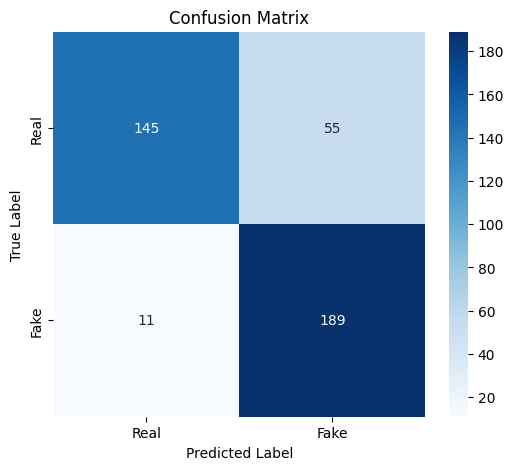


--- Classification Report ---
              precision    recall  f1-score   support

        Real       0.93      0.72      0.81       200
        Fake       0.77      0.94      0.85       200

    accuracy                           0.83       400
   macro avg       0.85      0.83      0.83       400
weighted avg       0.85      0.83      0.83       400



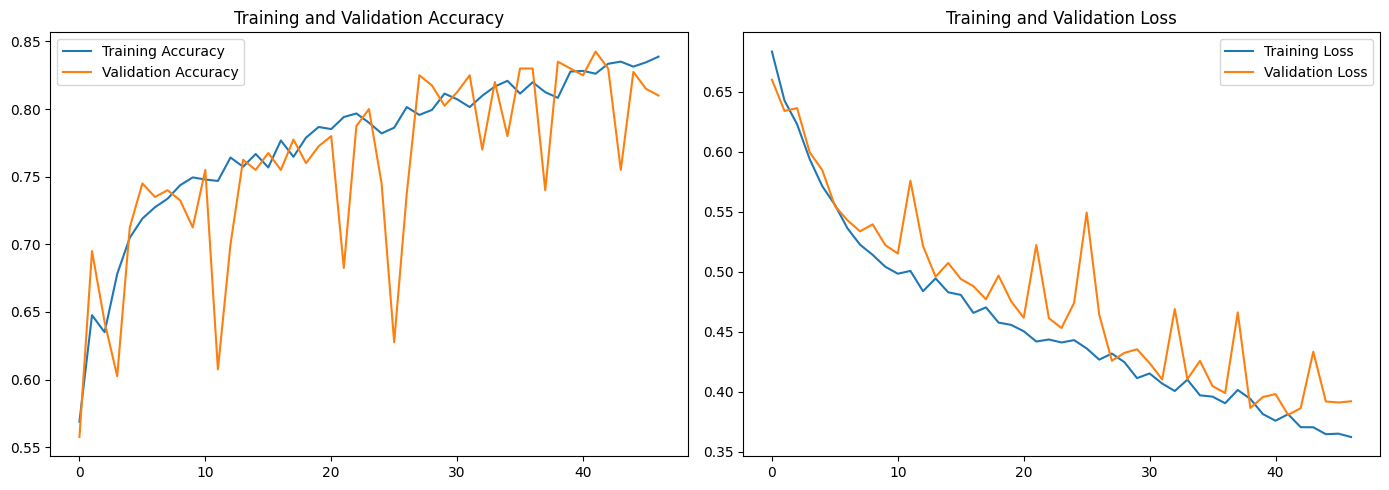

In [9]:
# ============================================================
# 9. CONFUSION MATRIX & PLOTS (UNCHANGED)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\n--- Classification Report ---")
print(classification_report(true_labels, pred_labels, target_names=['Real', 'Fake']))

acc = history.history['class_output_accuracy']
val_acc = history.history['val_class_output_accuracy']
loss = history.history['class_output_loss']
val_loss = history.history['val_class_output_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()